<a href="https://colab.research.google.com/github/amankiitg/5DParallel/blob/main/3_Activation_Recomputation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

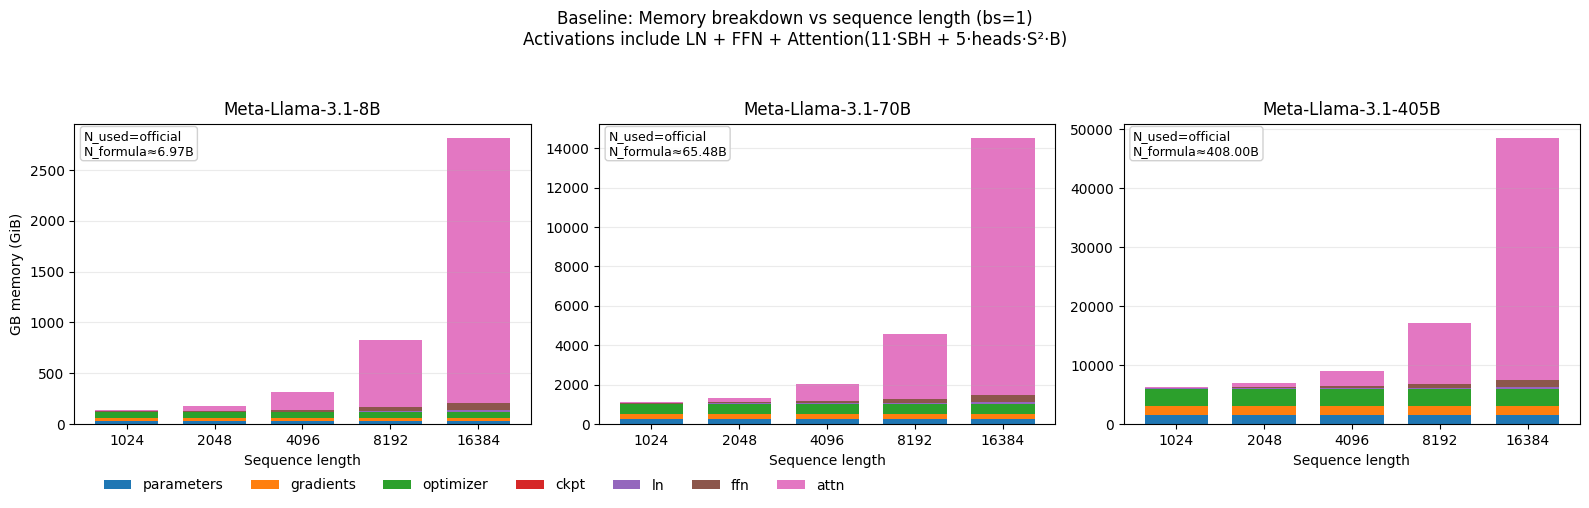

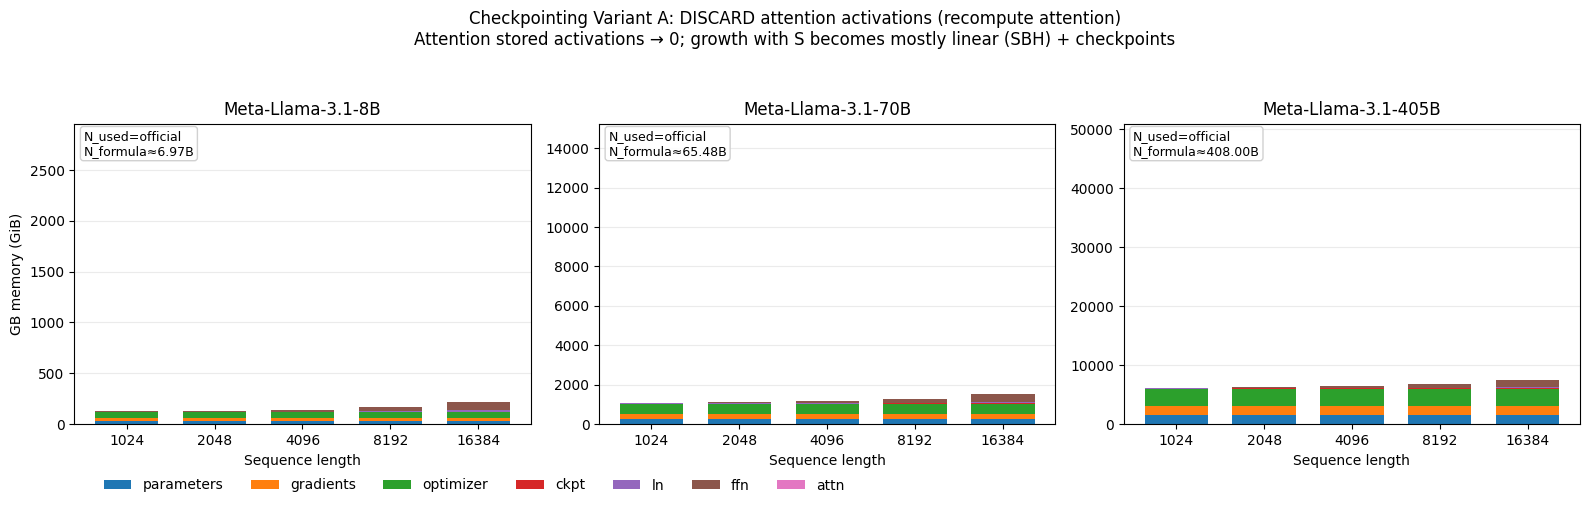

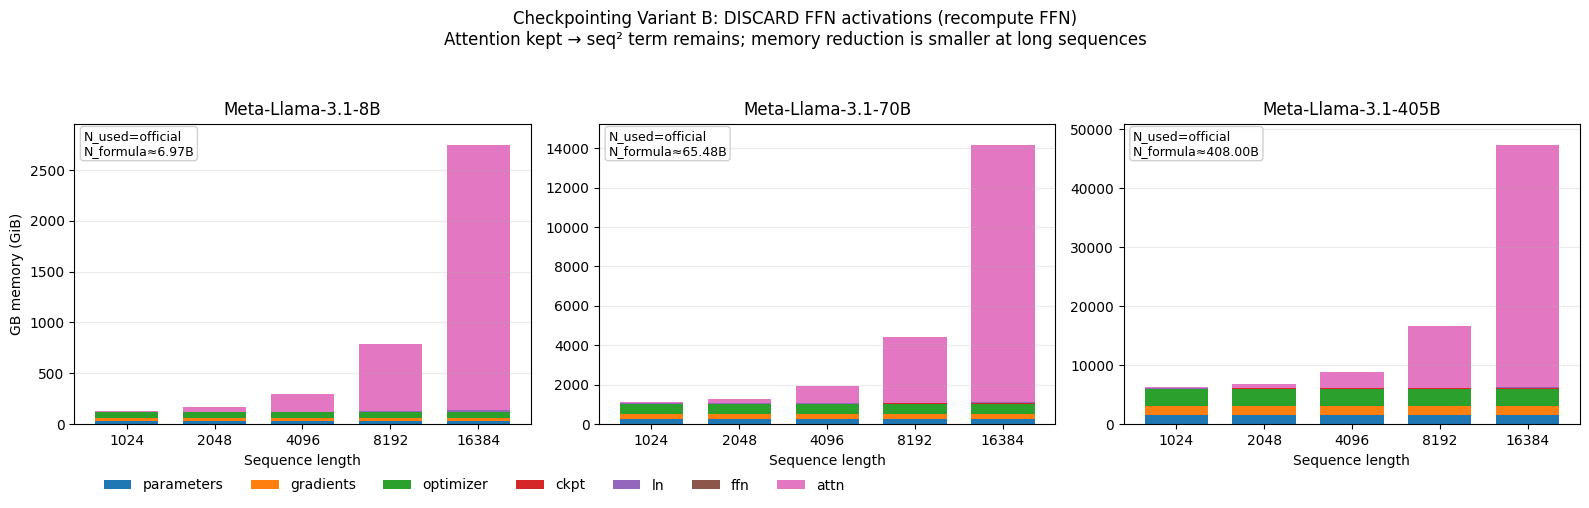

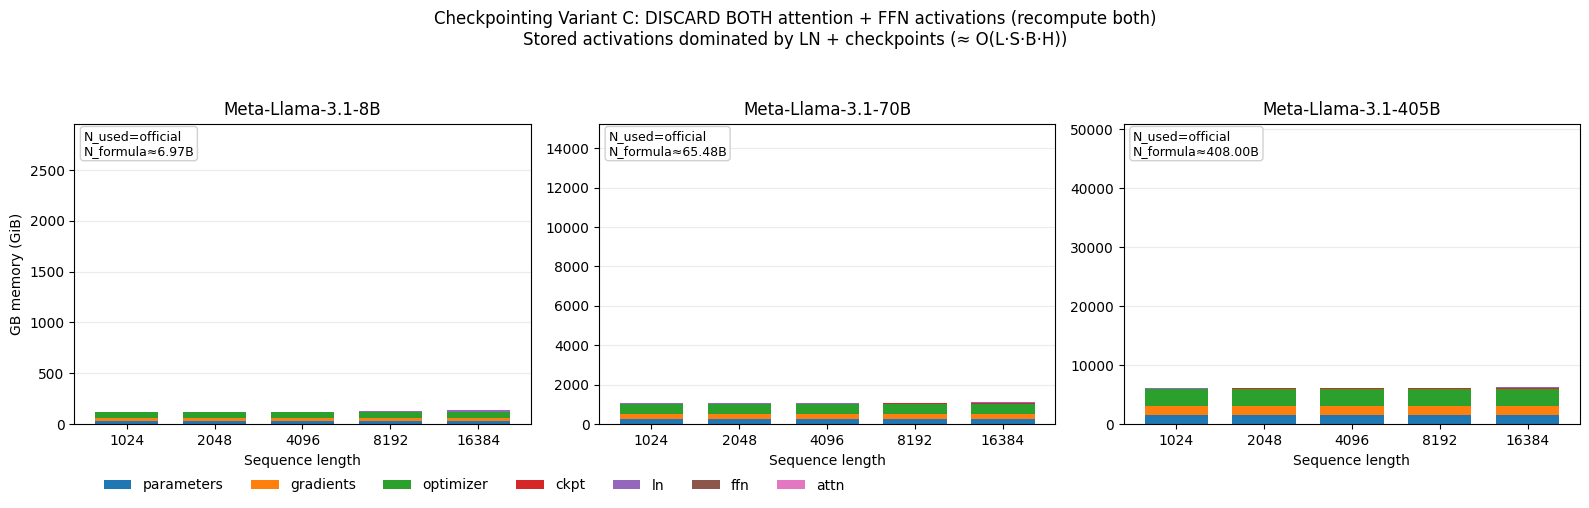

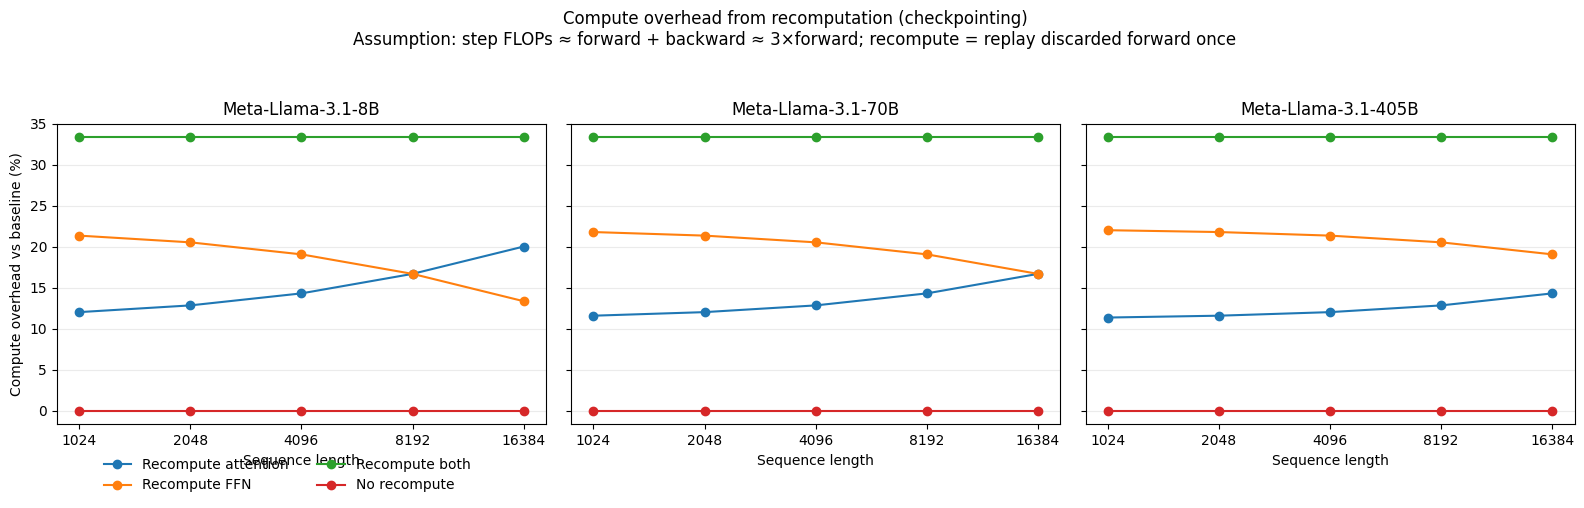

In [ ]:
# Colab-ready: Activation checkpointing (recompute) memory + compute overhead plots
# -------------------------------------------------------------------------------
# What you asked:
#  1) Baseline memory breakdown vs sequence length (like your stacked bars)
#  2) Same plot when ONLY attention activations are discarded (recomputed)
#  3) Same plot when ONLY FFN activations are discarded (recomputed)
#  4) Same plot when BOTH attention + FFN activations are discarded
#  5) A plot showing compute-time overhead vs sequence length for each strategy
#
# Key activation decomposition you gave (per transformer layer, in units of SBH):
#   - FFN activations:      19 * S*B*H
#   - LayerNorm activations: 4 * S*B*H
#   - Attention activations: 11 * S*B*H  +  5 * n_heads * S^2 * B
#
# When something is "discarded", it means those intermediates are NOT stored.
# For realism, when discarding anything we add "checkpoints" at layer boundaries:
#   checkpoint per layer ~= 1 * S*B*H  (you can tune this).
#
# Compute overhead model (simple but very useful for intuition):
#   total_step_flops ≈ forward + backward ≈ 3 * forward
#   If you discard a block, you replay (recompute) that block's forward once during backward.
#   compute_multiplier = 1 + (recompute_forward_flops) / (3 * forward_total_flops)
#
# NOTE: Llama uses GQA/SwiGLU/flash-attn etc; this is an analytical teaching plot.

import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 0) Helpers
# -----------------------------
def bytes_to_gib(x):
    return x / (1024**3)

def N_simple_transformer(h, v, L):
    # same estimate you used earlier (kept for reference)
    return h * v + L * (12 * (h**2) + 13 * h) + 2 * h

def m_params_bytes(N):  # fp32 params
    return 4 * N

def m_grad_bytes(N):    # fp32 grads
    return 4 * N

def m_opt_bytes(N):     # Adam m,v in fp32
    return 8 * N

# -----------------------------
# 1) Model configs (Llama 3.1 family)
# -----------------------------
V = 128256
models = {
    "Meta-Llama-3.1-8B":   {"h": 4096,  "L": 32,  "heads": 32,  "v": V, "N_official": 8e9},
    "Meta-Llama-3.1-70B":  {"h": 8192,  "L": 80,  "heads": 64,  "v": V, "N_official": 70e9},
    "Meta-Llama-3.1-405B": {"h": 16384, "L": 126, "heads": 128, "v": V, "N_official": 405e9},
}

USE_OFFICIAL_N = True
BS = 1
seqs = np.array([1024, 2048, 4096, 8192, 16384], dtype=int)

# -----------------------------
# 2) Activation memory pieces (per layer, in *elements*)
# -----------------------------
# You provided these SBH coefficients:
ATTN_LINEAR_SBH = 11
FFN_SBH         = 19
LN_SBH          = 4
ATTN_SEQ2_COEF  = 5  # multiplies (n_heads * S^2 * B)

# Activation dtype (bf16/fp16 ~ 2 bytes). Change to 4 for fp32.
ACT_DTYPE_BYTES = 2

# Checkpoint boundary tensors: store ~1 * SBH per layer when recomputing anything.
# (This is what makes checkpointing not "free" even if you discard everything.)
CHECKPOINT_SBH_PER_LAYER = 1

def activation_breakdown_bytes(cfg, seq, bs, strategy):
    """
    Returns dict of activation component bytes for the whole model (all layers):
      - 'ckpt'   : boundary checkpoints (only if discarding something)
      - 'ln'     : layernorm-related activations
      - 'ffn'    : FFN activations (stored only if not discarded)
      - 'attn'   : attention activations (stored only if not discarded),
                  includes both 11*SBH and 5*heads*S^2*B terms
    """
    h, L, a = cfg["h"], cfg["L"], cfg["heads"]
    S, B = seq, bs
    SBH = S * B * h

    discard_attn = strategy in ["discard_attn", "discard_both"]
    discard_ffn  = strategy in ["discard_ffn", "discard_both"]
    any_discard  = discard_attn or discard_ffn

    # Always keep LN activations (small); you could also recompute these but it's rarely worth it.
    ln_elems = L * (LN_SBH * SBH)

    # FFN stored unless discarded
    ffn_elems = 0 if discard_ffn else L * (FFN_SBH * SBH)

    # Attention stored unless discarded
    if discard_attn:
        attn_elems = 0
    else:
        attn_linear_elems = L * (ATTN_LINEAR_SBH * SBH)
        attn_seq2_elems   = L * (ATTN_SEQ2_COEF * a * (S**2) * B)  # your seq^2 term
        attn_elems = attn_linear_elems + attn_seq2_elems

    # Checkpoints (store boundary activations) only if discarding something
    ckpt_elems = 0 if not any_discard else L * (CHECKPOINT_SBH_PER_LAYER * SBH)

    return {
        "ckpt": ckpt_elems * ACT_DTYPE_BYTES,
        "ln":   ln_elems   * ACT_DTYPE_BYTES,
        "ffn":  ffn_elems  * ACT_DTYPE_BYTES,
        "attn": attn_elems * ACT_DTYPE_BYTES,
    }

# -----------------------------
# 3) FLOPs model for compute overhead
# -----------------------------
def forward_flops_attn(h, heads, S, B):
    """
    Simple attention forward FLOPs (per layer):
      projections (QKV + out): 8 * B * S * H^2
      attention matmuls:       4 * B * S^2 * H
    """
    return (8 * B * S * (h**2)) + (4 * B * (S**2) * h)

def forward_flops_ffn(h, S, B, expansion=4):
    """
    Simple MLP forward FLOPs (per layer) with expansion factor r:
      2 matmuls: 4 * B * S * r * H^2  -> for r=4 => 16 * B * S * H^2
    """
    r = expansion
    return 4 * B * S * r * (h**2)

def compute_multiplier(cfg, seq, bs, strategy, expansion=4):
    """
    Training-step compute multiplier relative to baseline with full activation storage.
    Assumption: total_step_flops ≈ forward + backward ≈ 3 * forward
    Recomputation: replay the discarded block's forward once during backward.
    """
    h, L, a = cfg["h"], cfg["L"], cfg["heads"]
    S, B = seq, bs

    f_attn = forward_flops_attn(h=h, heads=a, S=S, B=B)
    f_ffn  = forward_flops_ffn(h=h, S=S, B=B, expansion=expansion)
    f_total = f_attn + f_ffn

    # whole-model forward
    F = L * f_total

    # extra recompute forward
    extra = 0.0
    if strategy in ["discard_attn", "discard_both"]:
        extra += L * f_attn
    if strategy in ["discard_ffn", "discard_both"]:
        extra += L * f_ffn

    # total step ~ 3F, overhead = extra / (3F)
    return 1.0 + (extra / (3.0 * F))

# -----------------------------
# 4) Memory breakdown builder
# -----------------------------
def memory_breakdown_gib(cfg, N_used, seq, bs, strategy):
    """
    Returns per-category GiB dict:
      parameters, gradients, optimizer, ckpt, ln, ffn, attn, activations_total, total
    """
    p = bytes_to_gib(m_params_bytes(N_used))
    g = bytes_to_gib(m_grad_bytes(N_used))
    o = bytes_to_gib(m_opt_bytes(N_used))

    act_parts = activation_breakdown_bytes(cfg, seq, bs, strategy)
    ckpt = bytes_to_gib(act_parts["ckpt"])
    ln   = bytes_to_gib(act_parts["ln"])
    ffn  = bytes_to_gib(act_parts["ffn"])
    attn = bytes_to_gib(act_parts["attn"])
    acts_total = ckpt + ln + ffn + attn

    total = p + g + o + acts_total
    return {
        "parameters": p,
        "gradients": g,
        "optimizer": o,
        "ckpt": ckpt,
        "ln": ln,
        "ffn": ffn,
        "attn": attn,
        "activations_total": acts_total,
        "total": total,
    }

# -----------------------------
# 5) Plotting
# -----------------------------
def plot_memory_figure(strategy, title, y_max_by_model=None):
    """
    strategy: 'baseline' | 'discard_attn' | 'discard_ffn' | 'discard_both'
    """
    fig, axes = plt.subplots(1, 3, figsize=(16, 4.5), sharey=False)

    for ax, (name, cfg) in zip(axes, models.items()):
        h, L, a, v = cfg["h"], cfg["L"], cfg["heads"], cfg["v"]

        N_est = N_simple_transformer(h=h, v=v, L=L)
        N_used = cfg["N_official"] if USE_OFFICIAL_N else N_est

        # gather series across seqs
        series = {k: [] for k in ["parameters","gradients","optimizer","ckpt","ln","ffn","attn"]}
        totals = []

        for S in seqs:
            mb = memory_breakdown_gib(cfg, N_used, S, BS, strategy)
            for k in series.keys():
                series[k].append(mb[k])
            totals.append(mb["total"])

        x = np.arange(len(seqs))
        width = 0.72

        # stacked bars in an order that reads nicely
        bottom = np.zeros_like(x, dtype=float)
        for k in ["parameters", "gradients", "optimizer", "ckpt", "ln", "ffn", "attn"]:
            vals = np.array(series[k], dtype=float)
            ax.bar(x, vals, width, bottom=bottom, label=k)
            bottom += vals

        ax.set_title(name)
        ax.set_xticks(x)
        ax.set_xticklabels([str(s) for s in seqs])
        ax.set_xlabel("Sequence length")
        ax.grid(True, axis="y", alpha=0.25)

        # show N info
        ax.text(
            0.02, 0.98,
            f"N_used={'official' if USE_OFFICIAL_N else 'formula'}\nN_formula≈{N_est/1e9:.2f}B",
            transform=ax.transAxes, va="top", ha="left", fontsize=9,
            bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="0.8", alpha=0.9),
        )

        # fix y-limits to baseline max if provided (so reductions are obvious)
        if y_max_by_model is not None and name in y_max_by_model:
            ax.set_ylim(0, y_max_by_model[name])

    axes[0].set_ylabel("GB memory (GiB)")

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower left", bbox_to_anchor=(0.06, -0.05), ncol=7, frameon=False)

    fig.suptitle(title, y=1.05)
    plt.tight_layout()
    plt.show()

def compute_baseline_ymax():
    # compute per-model baseline max total memory (for consistent y-axis across strategy figures)
    y_max = {}
    for name, cfg in models.items():
        h, L, a, v = cfg["h"], cfg["L"], cfg["heads"], cfg["v"]
        N_est = N_simple_transformer(h=h, v=v, L=L)
        N_used = cfg["N_official"] if USE_OFFICIAL_N else N_est
        max_total = 0.0
        for S in seqs:
            mb = memory_breakdown_gib(cfg, N_used, S, BS, "baseline")
            max_total = max(max_total, mb["total"])
        y_max[name] = 1.05 * max_total
    return y_max

def plot_compute_overhead():
    # Compute overhead figure (three subplots, one per model; lines for strategies)
    strategies = {
        "discard_attn": "Recompute attention",
        "discard_ffn":  "Recompute FFN",
        "discard_both": "Recompute both",
        "baseline":     "No recompute",
    }

    fig, axes = plt.subplots(1, 3, figsize=(16, 4.5), sharey=True)

    for ax, (name, cfg) in zip(axes, models.items()):
        for strat, label in strategies.items():
            mult = np.array([compute_multiplier(cfg, S, BS, strat) for S in seqs], dtype=float)
            overhead_pct = (mult - 1.0) * 100.0
            ax.plot(seqs, overhead_pct, marker="o", label=label)

        ax.set_title(name)
        ax.set_xlabel("Sequence length")
        ax.grid(True, axis="y", alpha=0.25)
        ax.set_xscale("log", base=2)
        ax.set_xticks(seqs)
        ax.get_xaxis().set_major_formatter(lambda x, pos: f"{int(x)}")

    axes[0].set_ylabel("Compute overhead vs baseline (%)")
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower left", bbox_to_anchor=(0.06, -0.05), ncol=2, frameon=False)

    fig.suptitle(
        "Compute overhead from recomputation (checkpointing)\n"
        "Assumption: step FLOPs ≈ forward + backward ≈ 3×forward; recompute = replay discarded forward once",
        y=1.05
    )
    plt.tight_layout()
    plt.show()

# -----------------------------
# 6) Generate all requested plots
# -----------------------------
ymax = compute_baseline_ymax()

plot_memory_figure(
    "baseline",
    "Baseline: Memory breakdown vs sequence length (bs=1)\n"
    "Activations include LN + FFN + Attention(11·SBH + 5·heads·S²·B)",
    y_max_by_model=None  # baseline can autoscale
)

plot_memory_figure(
    "discard_attn",
    "Checkpointing Variant A: DISCARD attention activations (recompute attention)\n"
    "Attention stored activations → 0; growth with S becomes mostly linear (SBH) + checkpoints",
    y_max_by_model=ymax
)

plot_memory_figure(
    "discard_ffn",
    "Checkpointing Variant B: DISCARD FFN activations (recompute FFN)\n"
    "Attention kept → seq² term remains; memory reduction is smaller at long sequences",
    y_max_by_model=ymax
)

plot_memory_figure(
    "discard_both",
    "Checkpointing Variant C: DISCARD BOTH attention + FFN activations (recompute both)\n"
    "Stored activations dominated by LN + checkpoints (≈ O(L·S·B·H))",
    y_max_by_model=ymax
)

plot_compute_overhead()


## A note on calculating compute overhead

When you train a model for **one optimization step**, you do:

1. **Forward pass**: compute activations and the loss  
2. **Backward pass**: compute gradients via backpropagation

So the total compute per training step is:

\[
\text{FLOPs}_{\text{step}} = \text{FLOPs}_{\text{forward}} + \text{FLOPs}_{\text{backward}}
\]

---

### Why do we approximate: \(\text{backward} \approx 2 \times \text{forward}\)?

For the dominant operations in transformers (matrix multiplications), the backward pass typically needs **about two matmuls** per forward matmul.

Example: a linear layer

\[
Y = XW
\]

- Forward: compute \(Y\)
- Backward needs:
  - gradient w.r.t. weights:
    \[
    dW = X^\top dY
    \]
  - gradient w.r.t. inputs:
    \[
    dX = dY W^\top
    \]

Those two are each similar scale to the forward matmul, so we use the rule-of-thumb:

\[
\text{FLOPs}_{\text{backward}} \approx 2 \cdot \text{FLOPs}_{\text{forward}}
\]

Therefore:

\[
\text{FLOPs}_{\text{step}}
\approx \text{FLOPs}_{\text{forward}} + 2\cdot \text{FLOPs}_{\text{forward}}
= 3\cdot \text{FLOPs}_{\text{forward}}
\]

This is what the code comment meant:

> `total_step_flops ≈ forward + backward ≈ 3 * forward`

It’s an **approximation** (usually pretty good for GEMM-heavy models). The exact factor can vary depending on fused kernels (e.g., FlashAttention), implementation details, etc.

---

## How recomputation adds compute

Activation checkpointing/recompute works like this:

- During forward, you **do not store** some intermediate activations (to save memory).
- During backward, when those activations are needed, you **re-run the forward computation** for that block to regenerate them.

That means: **extra compute per step ≈ one extra forward of the discarded block**.

Let:

- \(F\) = total forward FLOPs for the whole model
- \(F_{\text{attn}}\) = forward FLOPs for the attention part (whole model)
- \(F_{\text{ffn}}\) = forward FLOPs for the FFN/MLP part (whole model)

### Baseline (no recompute)

\[
C_0 \approx 3F
\]

### If we discard attention activations (recompute attention)

We replay attention forward once during backward, so:

\[
C_{\text{attn-recompute}} \approx 3F + F_{\text{attn}}
\]

Compute multiplier:

\[
\frac{C_{\text{attn-recompute}}}{C_0}
\approx \frac{3F + F_{\text{attn}}}{3F}
= 1 + \frac{F_{\text{attn}}}{3F}
\]

### If we discard FFN activations (recompute FFN)

\[
\frac{C_{\text{ffn-recompute}}}{C_0}
\approx 1 + \frac{F_{\text{ffn}}}{3F}
\]

### If we discard both attention and FFN activations

\[
\frac{C_{\text{both-recompute}}}{C_0}
\approx 1 + \frac{F_{\text{attn}} + F_{\text{ffn}}}{3F}
\]

This is the exact logic used in the code’s “compute overhead” plot.

---

## Tiny numerical example (intuition)

Suppose per-layer **forward** FLOPs are:

- attention forward: \(100\)
- FFN forward: \(300\)

So total forward:

\[
F = 100 + 300 = 400
\]

Baseline step compute:

\[
C_0 \approx 3F = 1200
\]

### Recompute attention
\[
C \approx 1200 + 100 = 1300
\]
Overhead:
\[
\frac{1300}{1200}-1 = 8.33\%
\]

### Recompute FFN
\[
C \approx 1200 + 300 = 1500
\]
Overhead:
\[
\frac{1500}{1200}-1 = 25\%
\]

### Recompute both
\[
C \approx 1200 + 400 = 1600
\]
Overhead:
\[
\frac{1600}{1200}-1 = 33.3\%
\]

So recomputing the **smaller-compute** block adds less overhead.

---

## Why “recompute attention” can be a good trade
In many transformer setups:

- **Attention activations** can dominate memory (especially terms that scale like \(S^2\)).
- **FFN matmuls** often dominate compute.

So discarding (recomputing) attention can save a lot of memory while adding only a modest compute overhead.
